In [ ]:
# Import libraries
import numpy as np

from scipy.optimize import minimize
from scipy.interpolate import splprep, splev

import matplotlib as mpl
import matplotlib.pyplot as plt

import neuralfoil as nf

In [4]:
# Define the various functions for the optimization
def airfoil_efficiency(linkage_coordinates, alpha_in=0, Re_in=4.6e6):
    """
    Calculates the inverse of the aerodynamic efficiency of an airfoil from associated linkage control points.

    Args:
     linkage_coordinates (vector) : A numpy array of control points (n  linkage_coordinates 2) where each row is [x, y].
     alpha_in (scalar) : desired angle of attack for optimization (default is 0).
        Re_in (scalar) : desired Reynolds number for optimization (default is 2x10^6).
    
    Returns:
        1/efficiency (scalar) : Inverse of aerodynamic efficiency of the input linkage geometry
    """
    
    airfoil_coordinates = generate_airfoil_dat_from_points(linkage_coordinates, trailing_edge_smooth_factor=0.1)
    aero = nf.get_aero_from_coordinates(
        coordinates=airfoil_coordinates,
        #alpha=alpha_in,  # Switch to this to optimize just at 0 degree angle of attack
        alpha=np.linspace(0, 15, 1000),
        Re=Re_in,
        model_size="large"
    )
    #efficiency = aero['CL'][0]/aero['CD'][0] # Switch to this to optimize just at 0 degree angle of attack
    efficiency = np.max(aero['CL']/aero['CD'])

    inv_efficiency = 1/efficiency

    if efficiency < 0:
        inv_efficiency = 1000000000
    
    return inv_efficiency

def generate_airfoil_dat_from_points(points, display_plot=False, export_dat=False, additional_points=60, trailing_edge_smooth_factor=0.1):
    """
    Generate a smooth, mirrored, airfoil shape from a series of control points and save it to a .dat file.

    Parameters:
    - points: A numpy array of control points (n x 2) where each row is [x, y].
    - display_plot: Boolean flag to display the airfoil plot (default is False).
    - export_dat: Boolean flag to save the generated airfoil file (default is False).
    - additional_points: Number of extra points on the bottom surface (default is 60).
    - trailing_edge_smoothing_factor: Degree of curvature on the bottom surface (default is 0.1).
    
    Returns:
    - reordered_array_with_ends: [x,y] array of the generated airfoil coordinates.
    """

    offset_distance = points[9]

    direction = np.array([points[4] - points[2], points[5] - points[3]])

    direction_perp = [-direction[1], direction[0]]

    unit_vec = direction_perp / np.linalg.norm(direction_perp)

    midpoint = np.array([(points[2] + points[4])/2, (points[3] + points[5])/2])

    offsetpt = midpoint + offset_distance*unit_vec

    x = (0, points[0], points[2])
    y = (0, points[1], points[3])

    x_center = (points[2], offsetpt[0], points[4])
    y_center = (points[3], offsetpt[1], points[5])

    x_right = (points[4], points[6], 1)
    y_right = (points[5], points[7], 0)

    # Smooth the airfoil shape using splines
    tck, u = splprep([x, y], s=0.0, per=False, k=2)  # s is the smoothing factor
    x_spline, y_spline = splev(np.linspace(0, 1, 200), tck)

    tck2, u2 = splprep([x_center, y_center], s=0.0, per=False, k=2)  # s is the smoothing factor
    x_spline_center, y_spline_center = splev(np.linspace(0, 1, 200), tck2)

    tck3, u3 = splprep([x_right, y_right], s=0.0, per=False, k=2)  # s is the smoothing factor
    x_spline_right, y_spline_right = splev(np.linspace(0, 1, 200), tck3)

    # Identify the first and last points
    x1, y1 = x_spline[0], y_spline[0]  # First point
    x2, y2 = x_spline_right[-1], y_spline_right[-1]  # Last point

    # Generate symmetric control points for trailing edge curve
    cp1 = (0.5, y1 + trailing_edge_smooth_factor)  # Control point at symmetry axis
    cp2 = (0.5, y2 + trailing_edge_smooth_factor)

    # Generate points for the symmetric connection
    t = np.linspace(0, 1, additional_points)
    bezier_x = (1 - t)**2 * x1 + 2 * (1 - t) * t * cp1[0] + t**2 * x2
    bezier_y = (1 - t)**2 * y1 + 2 * (1 - t) * t * cp1[1] + t**2 * y2

    bezier_x_transpose = np.flip(bezier_x)
    bezier_y_transpose = np.flip(bezier_y)

    # Combine main airfoil and trailing edge curve
    x_final = np.concatenate([x_spline[:-1], x_spline_center, x_spline_right[1:], bezier_x_transpose[1:-1]])
    y_final = np.concatenate([y_spline[:-1], y_spline_center, y_spline_right[1:], bezier_y_transpose[1:-1]])

    airfoil_coordinates = np.array([x_final, y_final]).T

    halfway_index = len(airfoil_coordinates) // 2
    index_1 = np.argmin(np.abs(airfoil_coordinates[0:halfway_index,0]-points[0]) + np.abs(airfoil_coordinates[0:halfway_index,1] - points[1]))
    index_2 = np.argmin(np.abs(airfoil_coordinates[0:halfway_index,0]-points[2]) + np.abs(airfoil_coordinates[0:halfway_index,1] - points[3]))
    index_3 = np.argmin(np.abs(airfoil_coordinates[:,0] - points[4]) + np.abs(airfoil_coordinates[:,1] - points[5]))

    link1_mirror_x, link1_mirror_y = mirror_points(airfoil_coordinates[0:index_1-1,0], airfoil_coordinates[0:index_1-1,1])
    link2_mirror_x, link2_mirror_y = mirror_points(airfoil_coordinates[index_1:index_2,0], airfoil_coordinates[index_1:index_2,1])
    
    link1_mirrored_x, link1_mirrored_y = transform_curve(link1_mirror_x, link1_mirror_y, (link1_mirror_x[0], link1_mirror_y[0]), (link1_mirror_x[-1], link1_mirror_y[-1]), (1,0), (points[6], points[7]))
    link2_mirrored_x, link2_mirrored_y = transform_curve(link2_mirror_x, link2_mirror_y, (link2_mirror_x[0], link2_mirror_y[0]), (link2_mirror_x[-1], link2_mirror_y[-1]), (points[6], points[7]), (points[4], points[5]))
    
    airfoil_coordinates_x = np.concatenate([airfoil_coordinates[0:index_3,0], np.flip(link2_mirrored_x), np.flip(link1_mirrored_x), bezier_x_transpose[1:-1]])
    airfoil_coordinates_y = np.concatenate([airfoil_coordinates[0:index_3,1], np.flip(link2_mirrored_y), np.flip(link1_mirrored_y), bezier_y_transpose[1:-1]])

    airfoil_coordinates = np.column_stack((airfoil_coordinates_x, airfoil_coordinates_y))

    # Find the index of the rightmost point
    rightmost_index = np.argmax(airfoil_coordinates[:, 0])

    # Reorder the array
    reordered_array = np.concatenate([airfoil_coordinates[rightmost_index:], airfoil_coordinates[:rightmost_index]])

    # Now, the rightmost point is both at the start and the end
    reordered_array_with_ends = np.vstack([reordered_array, reordered_array[0]])

    # Display the plot if the flag is set to True
    if display_plot:
        plt.figure(figsize=(10, 5))
        plt.scatter(reordered_array_with_ends[:,0], reordered_array_with_ends[:,1], label="Airfoil Shape")
        plt.scatter(x, y, color='red', label="Control Points")
        plt.axis("equal")
        plt.legend()
        plt.title("Generated Airfoil Shape")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

    if 0:
        plt.figure(figsize=(10, 5))
        plt.plot(reordered_array_with_ends[:,0], label="Airfoil Shape")
        #plt.plot(np.flip(link1_mirrored_x), label="Airfoil Shape")
        plt.ylim(-1, 2) 
        plt.legend()
        plt.show()

    # Export the airfoil shape to a .dat file if the flag is set to True
    if export_dat:
        with open("optimized_airfoil.dat", "w") as f:
            f.write("Airfoil Shape Data\n")
            for xi, yi in zip(reordered_array_with_ends[:,0], reordered_array_with_ends[:,1]):
                f.write(f"{xi:.6f} {yi:.6f}\n")
        print('Dat file successfully written')

    return reordered_array_with_ends

def mirror_points(x, y, mirror_axis='vertical'):
    """
    Mirror points across the center of the curve.
    
    Parameters:
    - x, y: Arrays of x and y coordinates
    - mirror_axis: 'vertical' for mirroring across the curve's center y-axis, 
                   'horizontal' for mirroring across the curve's center x-axis
    
    Returns:
    - x_mirrored, y_mirrored: Mirrored coordinates
    """

    # Compute the center of the curve
    x_c = np.mean(x)
    y_c = np.mean(y)
    
    if mirror_axis == 'vertical':
        x_mirrored = 2 * x_c - x  # Reflect x about the center x_c
        y_mirrored = y
    elif mirror_axis == 'horizontal':
        x_mirrored = x
        y_mirrored = 2 * y_c - y  # Reflect y about the center y_c
    else:
        raise ValueError("Unsupported mirror axis. Use 'vertical' or 'horizontal'.")
    
    return x_mirrored, y_mirrored

def transform_curve(x, y, old_start, old_end, new_start, new_end):
    """
    Calculates and applies a translation and rotation to transform the old curve to the desired location.
    
    Parameters:
    - x, y: Arrays of x and y coordinates to be rotated and translated
    - old_start, old_end: Old start and end points as (x, y) tuples
    - new_start, new_end: New start and end points as (x, y) tuples
    
   Returns:
    - x_new, y_new: Transformed coordinates
    """
    
    # Calculate vectors for the old and new lines
    old_vector = (old_end[0] - old_start[0], old_end[1] - old_start[1])
    new_vector = (new_end[0] - new_start[0], new_end[1] - new_start[1])
    
    # Calculate the rotation angle using atan2
    old_angle = np.arctan2(old_vector[1], old_vector[0])
    new_angle = np.arctan2(new_vector[1], new_vector[0])
    rotation_angle = new_angle - old_angle

    pivot = (x[0], y[0])  # Rotate around the first point

    x_pivot, y_pivot = pivot

    # Translate points to origin
    x_translated = x - x_pivot
    y_translated = y - y_pivot

    # Compute rotation matrix
    cos_theta = np.cos(rotation_angle)
    sin_theta = np.sin(rotation_angle)

    # Apply rotation
    x_int = cos_theta * x_translated - sin_theta * y_translated
    y_int = sin_theta * x_translated + cos_theta * y_translated

    # Translate back
    x_int += x_pivot
    y_int += y_pivot

    # Calculate translation amounts
    dx = new_start[0] - x_int[0]
    dy = new_start[1] - y_int[0]

    # Apply the translation to the rotated curve
    x_new = x_int + dx
    y_new = y_int + dy

    return x_new, y_new

In [ ]:
# Define the optimization settings and solve

### CONSTRAINTS ###
# Small tolerance for relaxed equality constraints
epsilon = 1e-2

# Relaxed constraints: equality constraints with tolerance
constraints = [
    {'type': 'ineq', 'fun': lambda x: epsilon - abs((x[0]**2 + x[1]**2) - ((x[6]-1)**2 + x[7]**2))},  # l1^2 = l7^2 (relaxed)
    {'type': 'ineq', 'fun': lambda x: epsilon - abs(((x[2] - x[0])**2 + (x[3] - x[1])**2) - ((x[6]-x[4])**2+(x[7]-x[5])**2))},  # l2^2 = l6^2 (relaxed)
    {'type': 'ineq', 'fun': lambda x: epsilon - abs(((1/2-x[2])**2 + (x[8] - x[3])**2) - ((x[4]-1/2)**2+(x[5]-x[8])**2))},  # l3^2 = l5^2 (relaxed)
    
    # Convert equality constraints for pinned points to inequalities
    {'type': 'ineq', 'fun': lambda x: epsilon - abs(x[4] - x[2] - (np.sqrt((x[4]-x[2])**2+(x[5]-x[3])**2))*np.cos(np.arctan(np.sqrt(np.absolute(1-(np.sqrt((x[4]-x[2])**2+(x[5]-x[3])**2))**2/(4*(np.sqrt((1/2-x[2])**2+(x[8]-x[3])**2))**2))))))},  # Pinned x (relaxed)
    {'type': 'ineq', 'fun': lambda x: epsilon - abs(x[5] - x[3] + (np.sqrt((x[4]-x[2])**2+(x[5]-x[3])**2))*np.sin(np.arctan(np.sqrt(np.absolute(1-(np.sqrt((x[4]-x[2])**2+(x[5]-x[3])**2))**2/(4*(np.sqrt((1/2-x[2])**2+(x[8]-x[3])**2))**2))))))},  # Pinned y (relaxed)
    
    # Inequality constraints (apply penalties if violated)
    {'type': 'ineq', 'fun': lambda x: - x[0] + x[2]},
]

### BOUNDS ###
bounds = [(-5, 0), (0, 5), (0, 5), (0, 0.75), (0.5, 1.5), (0, 5), (1, 5), (-0.151, 5), (-5, 5), (0, 0.1)]

### INITIALIZATIONS ###
x0_1 = [-0.252, 0.160, -0.01, 0.304, 1.069, 0.09, 1.288, -0.084, 0.05, 0.1]
x0_2 = [-0.208, 0.243, 0.038, 0.377, 1.089, 0.051, 1.282, -0.151, 0.01, 0.1]
x0_3 = [-0.315, 0.057, 0.033, 0.265, 1.062, 0.17, 1.311, -0.077, 0.05, 0.1]
# x0_4 = [-0.31, 0.079, 0.026, 0.283, 1.066, 0.15, 1.3, -0.11, 0.05, 0.1] # Example of an unsuccessful initialization

### OPTIMIZER OPTIONS ###
options = {'initial_tr_radius': 0.01, 'verbose': 3, 'maxiter': 2000, 'barrier_tol': 1e-8, 'gtol': 1e-9, 'finite_diff_rel_step': 1e-5}

### SOLVE THE OPTIMIZATION ###
result_1 = minimize(airfoil_efficiency, x0_1, method='trust-constr', bounds=bounds, constraints=constraints, options=options)
result_2 = minimize(airfoil_efficiency, x0_2, method='trust-constr', bounds=bounds, constraints=constraints, options=options)
result_3 = minimize(airfoil_efficiency, x0_3, method='trust-constr', bounds=bounds, constraints=constraints, options=options)

### PRINT RESULTS ###
print("Optimal efficiency 1:", 1/result_1.fun)
print("Optimal efficiency 2:", 1/result_2.fun)
print("Optimal efficiency 3:", 1/result_3.fun)

print("Success 1:", result_1.success)
print("Success 2:", result_2.success)
print("Success 3:", result_3.success)

print('Optimization Complete')

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  11   |   0   | +2.1400e-02 | 1.00e-02 | 1.00e-01 | 5.38e-02 | 1.00e+00 |  1.00e-01   |   0   |


/opt/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


|   2   |  22   |   1   | +2.0931e-02 | 7.00e-02 | 7.58e-02 | 4.74e-02 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  33   |   7   | +2.0513e-02 | 4.88e-01 | 9.67e-02 | 5.72e-03 | 1.00e+00 |  1.00e-01   |   4   |
|   4   |  44   |  10   | +1.2410e-02 | 3.42e+00 | 5.36e-02 | 2.14e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   5   |  55   |  19   | +2.2322e-02 | 1.45e+01 | 4.86e-02 | 1.11e-01 | 1.00e+00 |  1.00e-01   |   4   |
|   6   |  66   |  25   | +2.2322e-02 | 1.45e+00 | 4.86e-02 | 1.11e-01 | 1.00e+00 |  1.00e-01   |   4   |
|   7   |  77   |  31   | +2.2322e-02 | 7.24e-01 | 4.86e-02 | 1.11e-01 | 1.00e+00 |  1.00e-01   |   4   |
|   8   |  88   |  34   | +2.8789e-02 | 1.45e+00 | 8.90e-02 | 3.95e-01 | 2.29e+00 |  1.00e-01   |   2   |
|   9   |  99   |  36   | +2.1864e-02 | 1.01e+01 | 3.92e-02 | 2.84e-01 | 6.50e+00 |  1.00e-01   |   2   |
|  10   |  110  |  43   | +2.1864e-02 | 1.32e+00 | 3.92e-02 | 2.84e-01 | 6.50e+00 |  1.00e-01   |   4   |
|  11   |  121  |  47   | +2.1864e-02 | 6.59e-

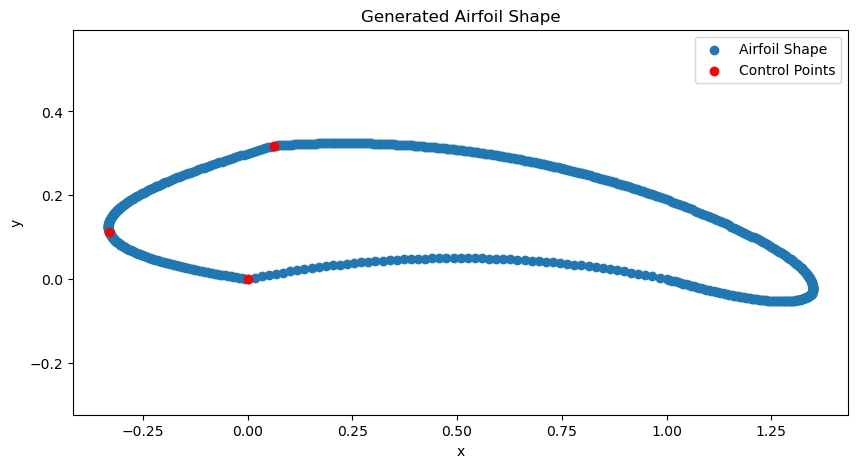

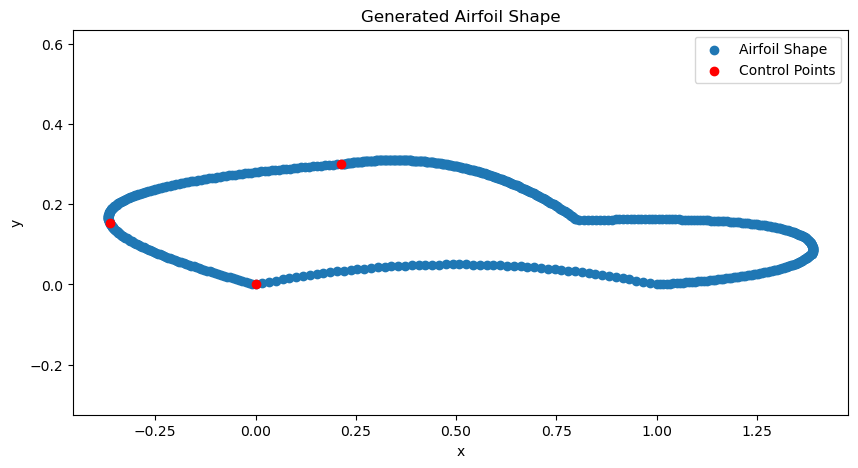

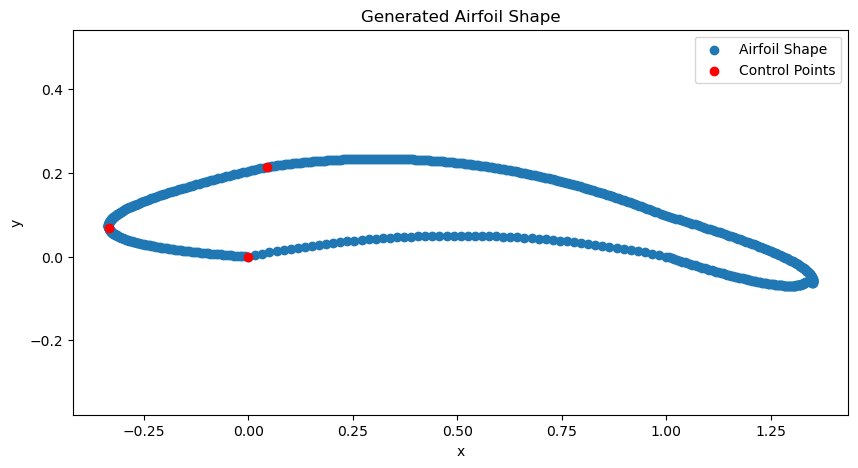

Dat file successfully written


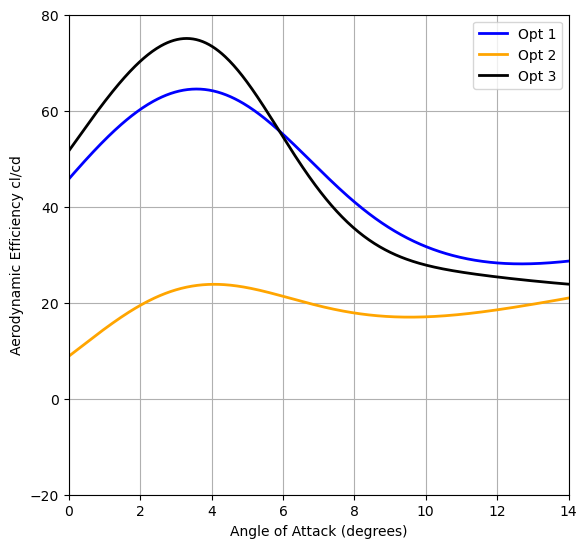

In [ ]:
### VISUALIZE THE RESULTS ###
efficiency_1 = airfoil_efficiency(result_1.x)
coords_1 = generate_airfoil_dat_from_points(result_1.x, display_plot=True, trailing_edge_smooth_factor=0.1, export_dat=False)

efficiency_2 = airfoil_efficiency(result_2.x)
coords_2 = generate_airfoil_dat_from_points(result_2.x, display_plot=True, trailing_edge_smooth_factor=0.1, export_dat=False)

efficiency_3 = airfoil_efficiency(result_3.x)
coords_3 = generate_airfoil_dat_from_points(result_3.x, display_plot=True, trailing_edge_smooth_factor=0.1, export_dat=True)

aero_gen_1 = nf.get_aero_from_coordinates(
        coordinates=coords_1,
        alpha=np.linspace(-10, 20, 1000),
        Re=4.6e6,
        model_size="xxxlarge"
)

aero_gen_2 = nf.get_aero_from_coordinates(
        coordinates=coords_2,
        alpha=np.linspace(-10, 20, 1000),
        Re=4.6e6,
        model_size="xxxlarge"
)

aero_gen_3 = nf.get_aero_from_coordinates(
        coordinates=coords_3,
        alpha=np.linspace(-10, 20, 1000),
        Re=4.6e6,
        model_size="xxxlarge"
)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0.1,0.1,0.5,0.8])
ax.plot(np.linspace(-10, 20, 1000), aero_gen_1['CL']/aero_gen_1['CD'], label="Optimization 1", linewidth=2, color="blue")
ax.plot(np.linspace(-10, 20, 1000), aero_gen_2['CL']/aero_gen_2['CD'], label="Optimization 2", linewidth=2, color="orange")
ax.plot(np.linspace(-10, 20, 1000), aero_gen_3['CL']/aero_gen_3['CD'], label="Optimization 3", linewidth=2, color="black")
plt.xlabel("Angle of Attack (degrees)")
plt.ylabel("Aerodynamic Efficiency cl/cd")
plt.legend(labels=['Opt 1', 'Opt 2', 'Opt 3', 'Opt 4'], loc='upper right')
plt.grid()
plt.xlim(0, 14) 
plt.ylim(-20, 80) 

plt.savefig("initialization_graph.svg", format="svg")